In [2]:
!python -m pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import nécessaire

In [4]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import glob
from google.colab import drive

# 2 Configuration des chemins Drive

In [5]:
drive.mount('/content/drive')

AUDIO_DIR = '/content/drive/MyDrive/dataset/bird_audio'
SAMPLE_RATE = 22050
DURATION = 5
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Define the path to your CSV files within Google Drive
CSV_DIR = '/content/drive/MyDrive/dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3 Lire les fichiers CSV avec les chemins dynamique

In [6]:
print(os.path.join(CSV_DIR, 'train_metadata_reduced.csv'))
metadata = pd.read_csv(os.path.join(CSV_DIR, 'train_metadata_reduced.csv'))
taxonomy = pd.read_csv(os.path.join(CSV_DIR, 'eBird_Taxonomy_v2021_reduced.csv'))

metadata['filepath'] = metadata.apply(lambda row: os.path.join(AUDIO_DIR, row['primary_label'], row['filename']), axis=1)


/content/drive/MyDrive/dataset/train_metadata_reduced.csv


# Étape 4 : Mettre à jour les fichiers CSV avec les informations du nouveau dataset.



In [7]:
NEW_DATASET_DIR = AUDIO_DIR

# Parcourir tous les fichiers du nouveau dataset
for bird_class in os.listdir(NEW_DATASET_DIR):
    class_dir = os.path.join(NEW_DATASET_DIR, bird_class)

    # Vérifier si le répertoire courant est un dossier
    if os.path.isdir(class_dir):
        for audio_file in os.listdir(class_dir):
            if audio_file.endswith('.ogg'): # Assurez-vous que vous ne traitez que les fichiers audio
                # Extraire les informations du fichier audio
                filename = audio_file
                primary_label = bird_class

                # Créer une nouvelle ligne pour le DataFrame metadata
                new_row = pd.DataFrame({'primary_label': [primary_label], 'filename': [filename]})

                # Ajouter la nouvelle ligne au DataFrame metadata
                metadata = pd.concat([metadata, new_row], ignore_index=True)

metadata.to_csv(os.path.join(CSV_DIR, 'train_metadata_reduced.csv'), index=False)
# Si vous avez également mis à jour taxonomy, sauvegardez-le également
taxonomy.to_csv(os.path.join(CSV_DIR, 'eBird_Taxonomy_v2021_reduced.csv'), index=False)




# 4 Affichage du debuggage / Filtrage

In [8]:
# Print the number of files found before filtering
print(f"Number of files found: {len(metadata)}")

# Print the first 5 filepaths to check if they are correct
print(metadata.head())

# Filter the metadata DataFrame *before* creating the 'filepath' column
metadata = metadata[metadata.apply(lambda row: os.path.exists(os.path.join(AUDIO_DIR, row['primary_label'], row['filename'])), axis=1)]


Number of files found: 18061
  primary_label secondary_labels              type  latitude  longitude  \
0       abethr1               []          ['song']    4.3906    38.2788   
1       abethr1               []          ['call']   -2.9524    38.2921   
2       abethr1               []          ['song']   -2.9524    38.2921   
3       abethr1               []          ['song']   -2.9524    38.2921   
4       abethr1               []  ['call', 'song']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
2  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
3  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
4  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.

# 5  Fonctions utilitaires pour la conversion audio

In [9]:
def load_audio(file_path, sr=SAMPLE_RATE, duration=DURATION):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, sr * duration - len(audio)))
    return audio

def extract_mel_spectrogram(audio, sr=SAMPLE_RATE):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def augment_audio(audio):
    if random.random() < 0.3:
        audio = audio + 0.005 * np.random.randn(len(audio))
    if random.random() < 0.3:
        audio = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=random.choice([-2, -1, 1, 2]))
    if random.random() < 0.3:
        rate = random.uniform(0.8, 1.2)
        # Adjust the call to time_stretch to use the 'rate' keyword argument within a dictionary.
        audio = librosa.effects.time_stretch(audio, rate=rate)
    return audio


SPEC_DIR = '/content/drive/MyDrive/dataset/spectrograms'


# 6 Préparation des spectrogrammes

In [10]:
def prepare_spectrograms():
    os.makedirs(SPEC_DIR, exist_ok=True)

    for bird_class in os.listdir(AUDIO_DIR):
        class_dir = os.path.join(AUDIO_DIR, bird_class)
        output_class_dir = os.path.join(SPEC_DIR, bird_class)

        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        if os.path.isdir(class_dir):
            print(f"Processing {bird_class}...")
            for audio_file in os.listdir(class_dir):
                if audio_file.endswith('.ogg'):
                    audio_path = os.path.join(class_dir, audio_file)
                    spec_path = os.path.join(output_class_dir, audio_file.replace('.ogg', '.png'))

                    if not os.path.exists(spec_path):
                        # Charger et augmenter l'audio
                        audio = load_audio(audio_path)
                        audio = augment_audio(audio)

                        # Créer et sauvegarder le spectrogramme
                        mel_spec = extract_mel_spectrogram(audio)
                        plt.imsave(spec_path, mel_spec, cmap='viridis')

# 7 Création des datasets

In [11]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def create_dataset():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        SPEC_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        SPEC_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    class_names = train_ds.class_names
    num_classes = len(class_names)

    return train_ds, val_ds, num_classes

# 8 Préparation des données


In [12]:
print("Preparing spectrograms...")
prepare_spectrograms()

print("Creating datasets...")
train_ds, val_ds, num_classes = create_dataset()

# Optimisation des performances
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Preparing spectrograms...
Processing barswa...
Processing comsan...
Processing wlwwar...
Processing woosan...
Processing eaywag1...
Processing thrnig1...
Creating datasets...
Found 3131 files belonging to 12 classes.
Using 2505 files for training.
Found 3131 files belonging to 12 classes.
Using 626 files for validation.


# 9 Création du modèle

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 10 Compilation du modèle

In [14]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


#  11 Entraînement du modèle

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=15,
    #         restore_best_weights=True
    #     )
    # ]
)


Epoch 1/50
69/79 ━━━━━━━━━━━━━━━━━━━━ 1:17 8s/step - accuracy: 0.1407 - loss: 40.4145

KeyboardInterrupt: 

# 12 Visualisation des résultats


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 13 Sauvegarde du modèle

In [ ]:
model.save('bird_audio_classifier_v2.h5')

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Increased dropout rate

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Increased dropout rate

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Increased dropout rate

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),  # Add random zoom
    tf.keras.layers.RandomContrast(0.2)  # Add random contrast adjustment
])

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Training with early stopping and learning rate reduction
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=50,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=10,  # Increased patience
    #         restore_best_weights=True
    #     ),
    #     tf.keras.callbacks.ReduceLROnPlateau(
    #         monitor='val_loss',
    #         factor=0.5,
    #         patience=3,
    #         verbose=1
    #     )
    # ]
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),  # Add random zoom
    tf.keras.layers.RandomContrast(0.2)  # Add random contrast adjustment
])

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Training with early stopping and learning rate reduction
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_737']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


79/79 ━━━━━━━━━━━━━━━━━━━━ 59s 194ms/step - accuracy: 0.1905 - loss: 2.3047 - val_accuracy: 0.3450 - val_loss: 1.8930
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.4160 - loss: 1.6642 - val_accuracy: 0.4936 - val_loss: 1.5052
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.5462 - loss: 1.3617 - val_accuracy: 0.5495 - val_loss: 1.3080
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.6051 - loss: 1.1489 - val_accuracy: 0.6038 - val_loss: 1.2064
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.6537 - loss: 1.0392 - val_accuracy: 0.6198 - val_loss: 1.1722
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.6681 - loss: 0.9633 - val_accuracy: 0.6246 - val_loss: 1.1195
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.7085 - loss: 0.8384 - val_accuracy: 0.6565 - val_loss: 1.0317
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.7310 - loss: 0.7798 - val_accuracy: 0.675

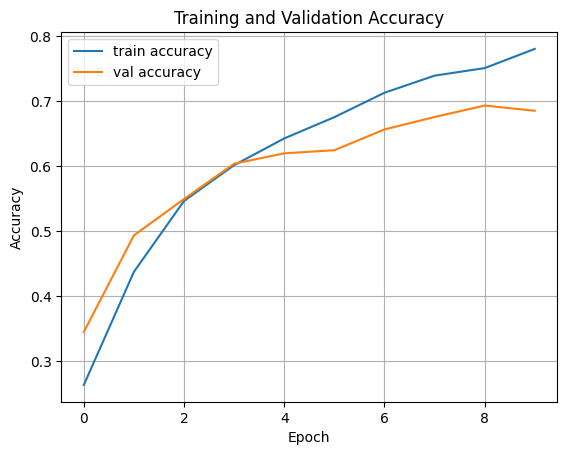

In [21]:
# 🔥 Utilisation d'un modèle pré-entraîné EfficientNetB0 pour la classification des spectrogrammes

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, RandomFlip, RandomRotation # Import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
#from tensorflow.keras.layers.experimental import preprocessing # Import preprocessing -> No longer needed


# Définir les dimensions d'entrée
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3  # RGB

# Définir l'entrée
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Charger EfficientNetB0 sans la couche de classification finale
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Fine-tuning : débloquer les couches supérieures et laisser le modèle de base entraînable
for layer in base_model.layers[-20:]:
    layer.trainable = True
base_model.trainable = True # Laisser le modèle de base entraînable

# Augmentation des données
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"), # Use RandomFlip directly from keras.layers
    RandomRotation(0.2), # Use RandomRotation directly from keras.layers
])

# Appliquer l'augmentation des données à l'entrée
x = data_augmentation(inputs)

# Passer l'entrée augmentée au modèle de base
x = base_model(x, training=False)

# Ajouter une tête de classification
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs, outputs)

# Compiler le modèle avec un taux d'apprentissage légèrement plus élevé
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Afficher les courbes d'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [22]:
model.save('bird_audio_classifier_EfficientNetB0.h5')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1229']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 178ms/step - accuracy: 0.1957 - loss: 2.2741 - val_accuracy: 0.3642 - val_loss: 1.9075
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.4308 - loss: 1.6572 - val_accuracy: 0.4936 - val_loss: 1.4965
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.5287 - loss: 1.3965 - val_accuracy: 0.5655 - val_loss: 1.3560
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.5981 - loss: 1.1846 - val_accuracy: 0.6054 - val_loss: 1.2740
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.6216 - loss: 1.1025 - val_accuracy: 0.6230 - val_loss: 1.2210
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.6559 - loss: 0.9584 - val_accuracy: 0.6374 - val_loss: 1.2064
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.6890 - loss: 0.8653 - val_accuracy: 0.6422 - val_loss: 1.1814
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.7245 - loss: 0.8057 - val_accuracy: 0.659

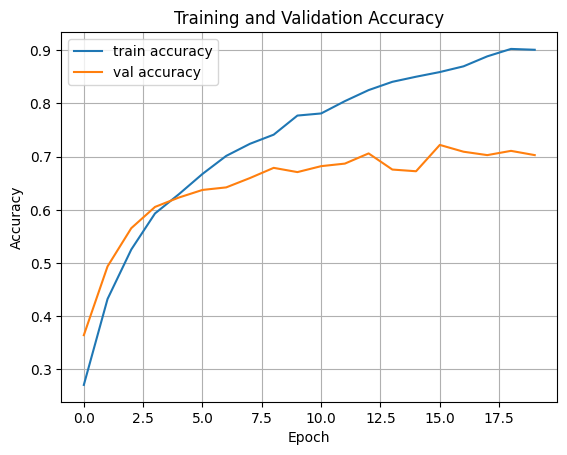

In [25]:
# 🔥 Utilisation d'un modèle pré-entraîné EfficientNetB0 pour la classification des spectrogrammes

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, RandomFlip, RandomRotation # Import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
#from tensorflow.keras.layers.experimental import preprocessing # Import preprocessing -> No longer needed


# Définir les dimensions d'entrée
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3  # RGB

# Définir l'entrée
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Charger EfficientNetB0 sans la couche de classification finale
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Fine-tuning : débloquer les couches supérieures et laisser le modèle de base entraînable
for layer in base_model.layers[-60:]:
    layer.trainable = True
base_model.trainable = True # Laisser le modèle de base entraînable

# Augmentation des données
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"), # Use RandomFlip directly from keras.layers
    RandomRotation(0.2), # Use RandomRotation directly from keras.layers
])

# Appliquer l'augmentation des données à l'entrée
x = data_augmentation(inputs)

# Passer l'entrée augmentée au modèle de base
x = base_model(x, training=False)

# Ajouter une tête de classification
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs, outputs)

# Compiler le modèle avec un taux d'apprentissage légèrement plus élevé
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

# Afficher les courbes d'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [26]:
model.save('bird_audio_classifier_EfficientNetB0.h5')